In [1]:
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Rs with empkep

In [3]:
res_prefix = 'mcmc_test_1' # t1 -- > Normal results with corrections, t0 before corrections

#### Some functions

In [4]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [5]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e11, Ncol[1], 1.e19]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.e-7

    fig, ax = model.makegrid(lines = 'c18o', J1=3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None))

            
    # Get theoretical errors
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=None, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=None, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])

    print(Tb7_thr_err)

    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print(Tb6_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    ax.errorbar(tb7, tb6, xerr = np.sqrt(1.08**2),   # (0.1*tb7)**2 + 1.08**2
                yerr = np.sqrt(0.49**2),  # (0.1*tb6)**2 + 0.49**2
                color = 'red', marker = 'o', ms=5, label = 'Observed')
    
    ax.set_ylim(0,20)
    ax.set_xlim(0,20)

    plt.grid()

    
    plt.legend(prop={'size': 6})


    return fig, ax, (Tb_6_pred[4], Tb_6_err) , (Tb_7_pred[4], Tb_7_err)

#### Generate the Data

In [15]:


np.random.seed(47)
lg_N_large = np.abs(np.random.uniform(low=13.5,high=18., size = 100))
Texe_large = np.abs(np.random.uniform(low=5,high=40, size = 100))

lg_N = []
Texe = []

# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')


Tb7 = []
Tb7_with_rand_error = []
Tb7_with_rand_error_nobnd = []
Tb6 = []
Tb6_with_rand_error = []
Tb6_with_rand_error_nobnd = []

for index, (lg_n,texe) in enumerate(zip(lg_N_large,Texe_large)):

    tb7_i = lte_model.get_intensity(line = 'c18o', Ju = 3, Ncol = 10**lg_n, Tex = texe, delv = 7417.8, Xconv=None)
    tb6_i = lte_model.get_intensity(line = 'c18o', Ju = 2, Ncol = 10**lg_n, Tex = texe, delv = 7417.8, Xconv=None)


    if  2.3<=tb7_i<= 15 and 2.3<=tb6_i<= 15:

        lg_N.append(lg_n)
        Texe.append(texe)

        Tb7.append(tb7_i)
        Tb6.append(tb6_i)

        Tb7_with_rand_error.append(np.abs(np.random.normal(loc=Tb7[-1], scale=np.sqrt(1.08**2 + (0.1*Tb7[-1])**2))))
        Tb6_with_rand_error.append(np.abs(np.random.normal(loc=Tb6[-1], scale=np.sqrt(0.49**2 + (0.1*Tb6[-1])**2))))

        Tb7_with_rand_error_nobnd.append(np.abs(np.random.normal(loc=Tb7[-1], scale=abs(0.9*Tb7[-1]))))
        Tb6_with_rand_error_nobnd.append(np.abs(np.random.normal(loc=Tb6[-1], scale=abs(0.9*Tb6[-1]))))
    
    if len(Tb6)>=15:
        lg_N
        break

#### Data visualization (data without noise)

lg_N [16.78, 16.41, 16.68, 14.61, 14.65, 14.85, 16.38, 14.95, 14.33, 17.63, 14.72, 14.73, 16.86, 17.36, 14.82]
lg T [16.02, 14.8, 18.92, 38.37, 17.24, 26.41, 17.09, 21.76, 39.4, 11.82, 16.35, 39.19, 7.79, 10.9, 36.56]
15 15
15


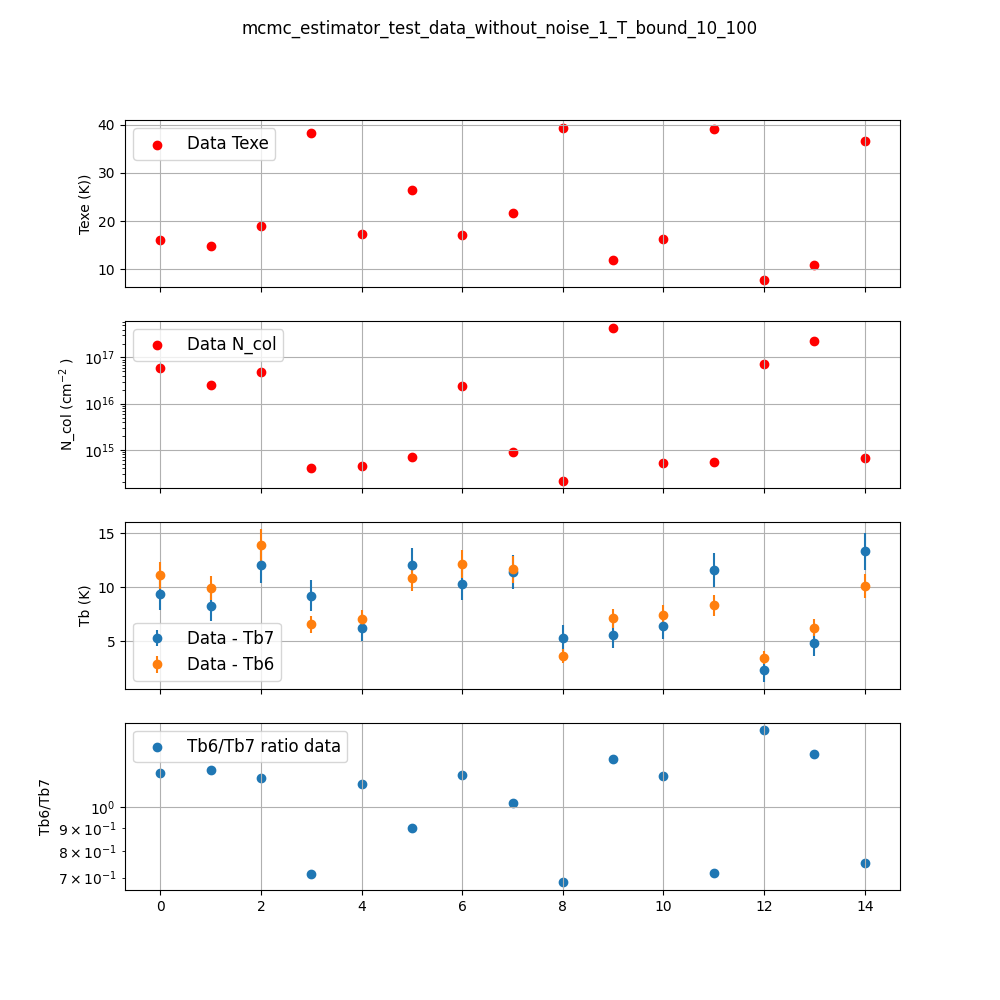

In [16]:
op_dir_label = "mcmc_estimator_test_data_without_noise_1_T_bound_10_100"
print("lg_N",[round(n,2) for n in lg_N])
print("lg T",[round(t,2) for t in Texe])


vis_data_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

# N_conv_fraction = 1.e-7
r = np.arange(len(Tb7))
print(len(Tb6), len(Tb7))
print(len(lg_N))


axes[1].scatter(r, 10**np.array(lg_N), marker='o', color = 'r', label = 'Data N_col')
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 12})

axes[0].scatter(r, Texe, marker='o', color = 'r', label = 'Data Texe')
axes[0].set_ylabel(r"Texe (K))")
axes[0].grid(True)
axes[0].legend(prop={'size': 12})

axes[2].errorbar(r, Tb7, yerr=np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), 
                 label = 'Data - Tb7', fmt='o')
axes[2].errorbar(r, Tb6, yerr=np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), 
                 label = 'Data - Tb6', fmt='o')
axes[2].set_ylabel(r"Tb (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 12})

axes[3].scatter(r, np.array(Tb6)/np.array(Tb7), marker='o', label = 'Tb6/Tb7 ratio data')
axes[3].set_ylabel(r"Tb6/Tb7")
axes[3].set_yscale('log')
axes[3].grid(True)
axes[3].legend(prop={'size': 12})


vis_data_fig.suptitle(op_dir_label)

vis_results_figname =  op_dir_label + ".jpeg"
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_data_figpath = os.path.join(dir_path, vis_results_figname)
vis_data_fig.savefig(fname = vis_data_figpath, dpi=300, format='jpeg')



#### T estimation loop (data without noise)

In [17]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for i = 0 , Tb7 = 9.3, Tb6 = 11.1


100%|██████████| 10000/10000 [00:32<00:00, 303.20it/s]
d:\L1489_IRS_ssp\LTEAnalysis\Tb_estimator.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
C:\Users\mihirkumar\AppData\Local\Temp\ipykernel_23388\2746674367.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure(figsize=(10,10))


dtauv_dT =  40.66646092905906
dtauv_dT =  24.20725485768804
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.92, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 2.24e+23, lgNc = 2.33e+01
Ncols and lgNcols med 7.33e+19, lgNc = 1.99e+01
Ncols and lgNcols dwn 1.96e+16, lgNc = 1.63e+01
del T -> + 0.51, - 0.46
del N -> + 2.24e+23, - 7.33e+19
[[0.4246297  0.47334408]]
[[0.44389316 0.49481749]]


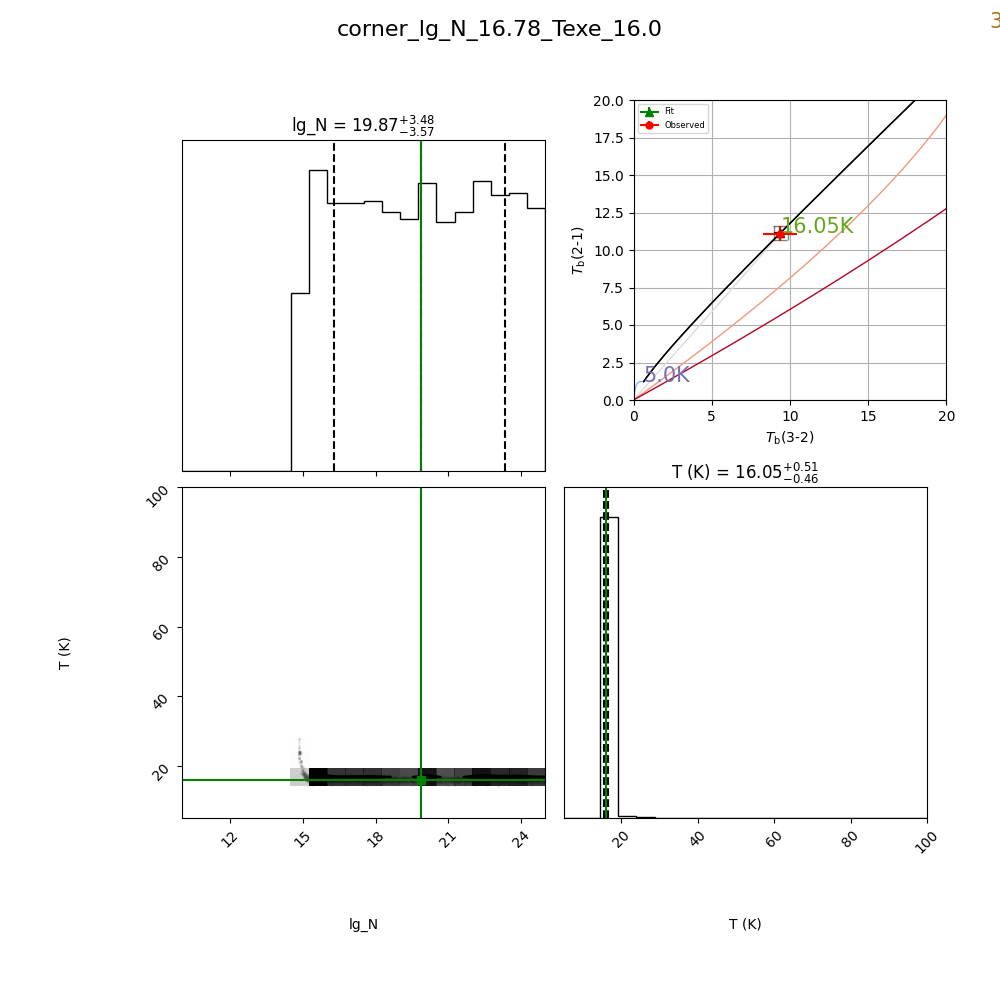

estimating for i = 1 , Tb7 = 8.2, Tb6 = 9.9


100%|██████████| 10000/10000 [00:24<00:00, 404.96it/s]


dtauv_dT =  23.06406617880533
dtauv_dT =  14.864735433170498
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.91, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 1.31e+23, lgNc = 2.31e+01
Ncols and lgNcols med 3.09e+19, lgNc = 1.95e+01
Ncols and lgNcols dwn 8.28e+15, lgNc = 1.59e+01
del T -> + 0.57, - 0.50
del N -> + 1.31e+23, - 3.09e+19
[[0.45326524 0.52151096]]
[[0.47732394 0.54919205]]


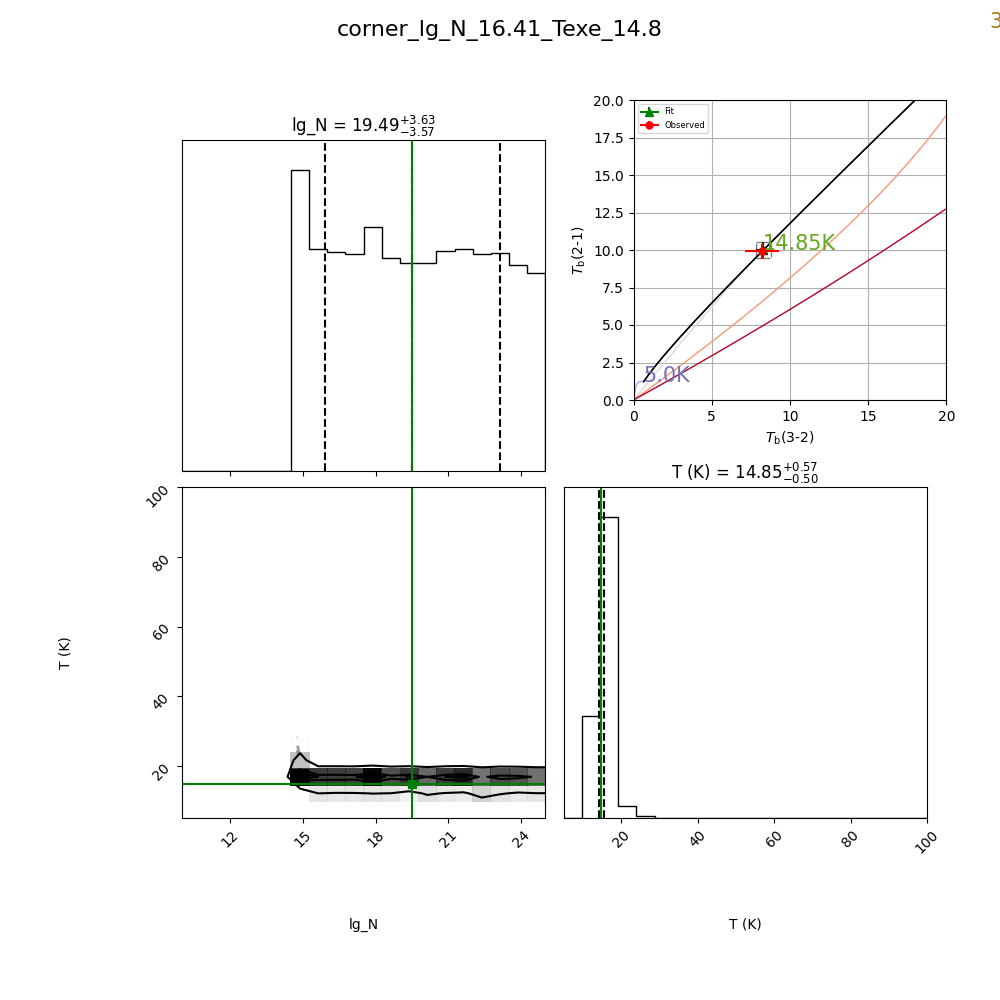

estimating for i = 2 , Tb7 = 12.1, Tb6 = 13.9


100%|██████████| 10000/10000 [00:35<00:00, 284.80it/s]


dtauv_dT =  26.235326401167956
dtauv_dT =  13.431838933954477
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.94, Tb6_dIv_dT = 0.97
Ncols and lgNcols up 2.18e+23, lgNc = 2.33e+01
Ncols and lgNcols med 9.32e+19, lgNc = 2.00e+01
Ncols and lgNcols dwn 3.06e+16, lgNc = 1.65e+01
del T -> + 0.53, - 0.48
del N -> + 2.18e+23, - 9.31e+19
[[0.45746282 0.49913329]]
[[0.47230336 0.51532566]]


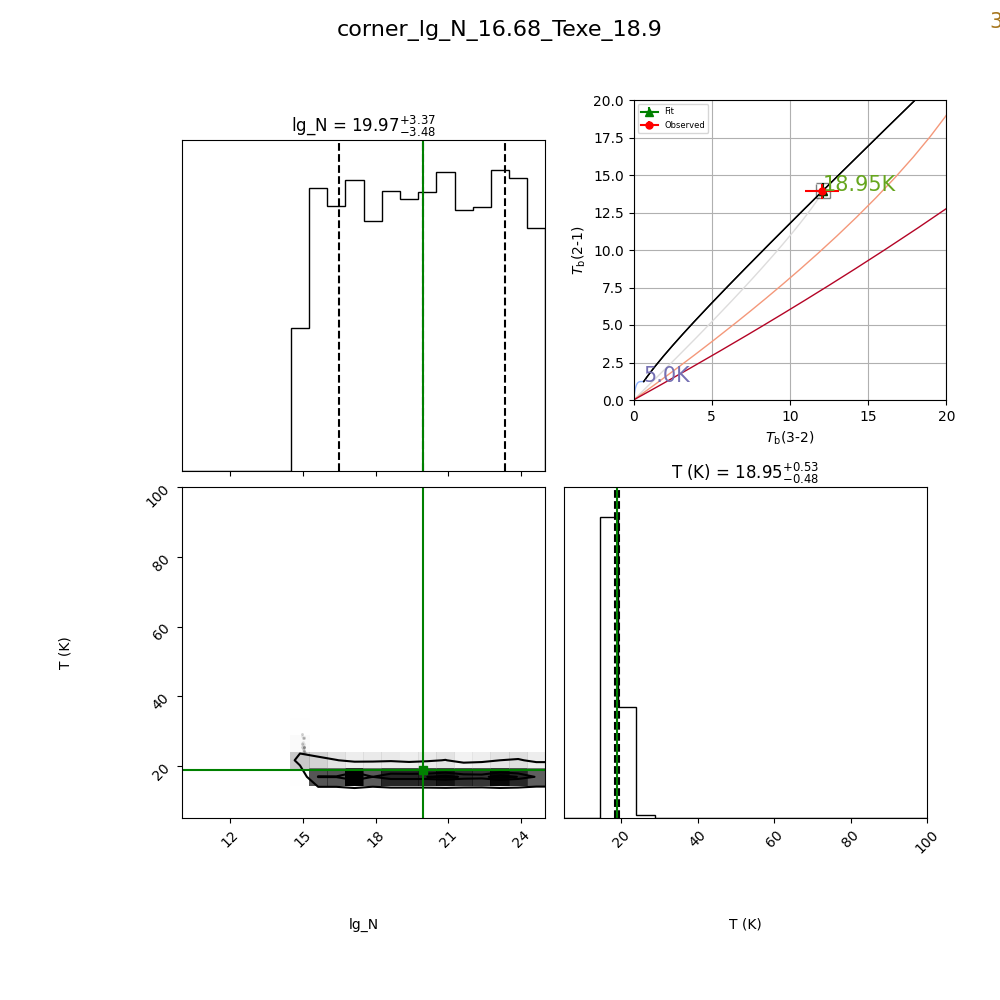

estimating for i = 3 , Tb7 = 9.2, Tb6 = 6.6


100%|██████████| 10000/10000 [00:23<00:00, 430.31it/s]


dtauv_dT =  4.876513047378048e-06
dtauv_dT =  1.6409282558052646e-06
Tb7_dIv_dN = 1.77e-14, Tb6_dIv_dN = 1.39e-14
Tb7_dIv_dT = 0.33, Tb6_dIv_dT = 0.23
Ncols and lgNcols up 4.43e+18, lgNc = 1.86e+01
Ncols and lgNcols med 4.75e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 3.96e+14, lgNc = 1.46e+01
del T -> + 25.14, - 26.11
del N -> + 4.43e+18, - 7.89e+13
[[8.74128376 8.41772067]]
[[5.93060582 5.71108223]]


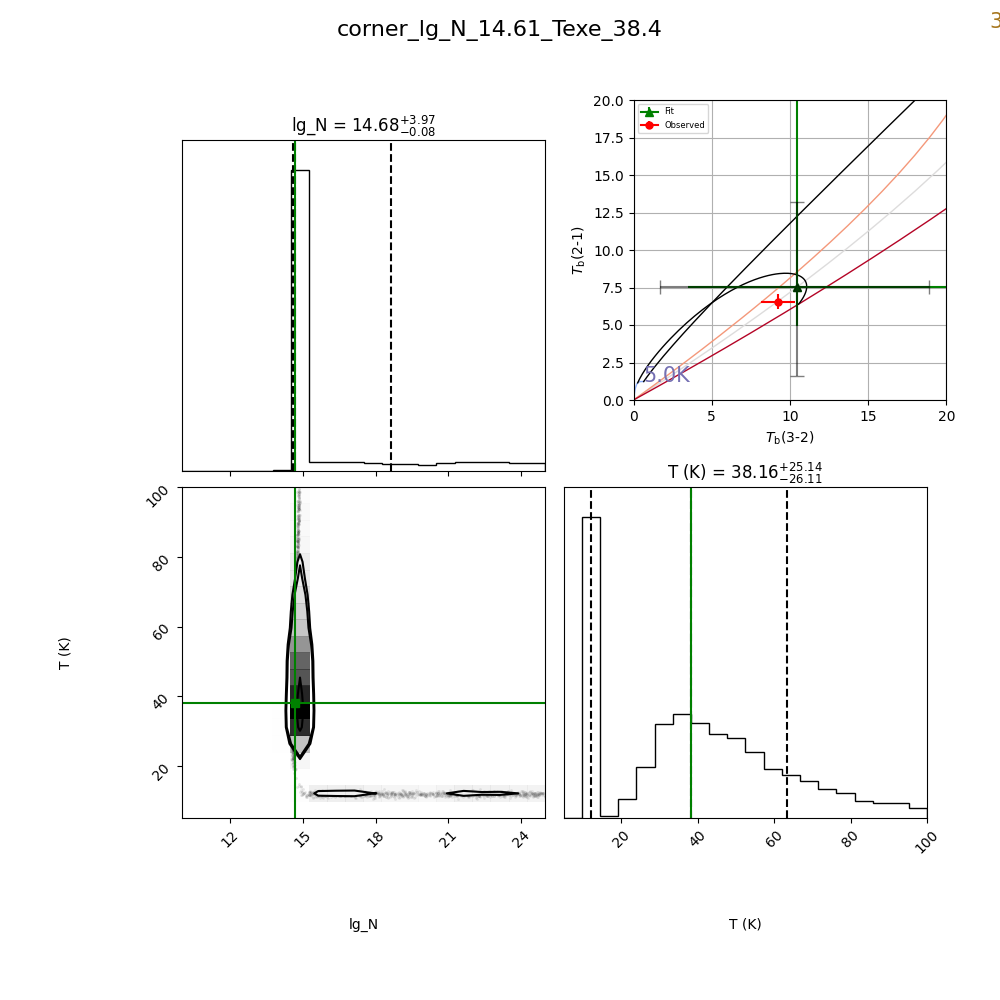

estimating for i = 4 , Tb7 = 6.2, Tb6 = 7.0


100%|██████████| 10000/10000 [00:51<00:00, 193.82it/s]


dtauv_dT =  30.5174840396408
dtauv_dT =  25.445498292171216
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.87, Tb6_dIv_dT = 0.94
Ncols and lgNcols up 1.78e+23, lgNc = 2.32e+01
Ncols and lgNcols med 1.92e+19, lgNc = 1.93e+01
Ncols and lgNcols dwn 1.88e+15, lgNc = 1.53e+01
del T -> + 0.73, - 0.54
del N -> + 1.78e+23, - 1.92e+19
[[0.46872175 0.63044726]]
[[0.50735998 0.68241704]]


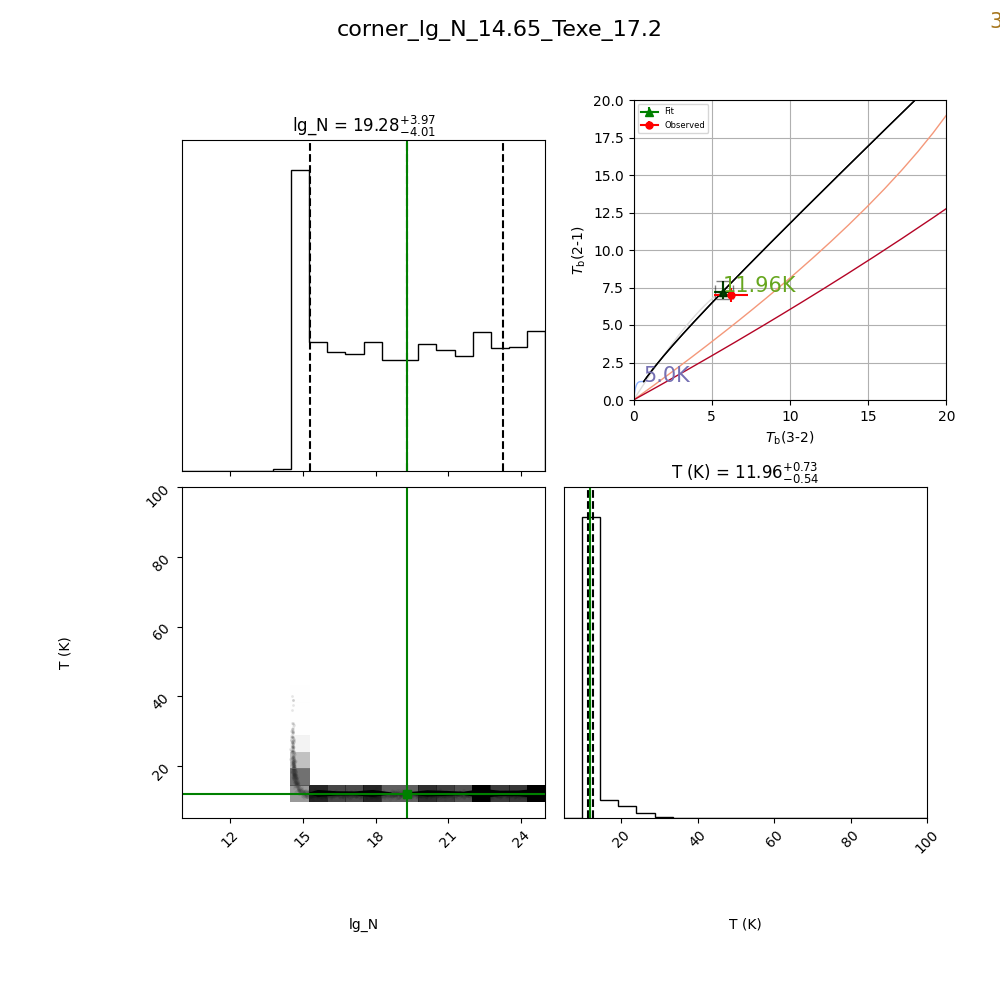

estimating for i = 5 , Tb7 = 12.0, Tb6 = 10.8


100%|██████████| 10000/10000 [00:24<00:00, 400.45it/s]


dtauv_dT =  0.007428101630928047
dtauv_dT =  0.004218246006210484
Tb7_dIv_dN = 7.86e-29, Tb6_dIv_dN = 4.32e-28
Tb7_dIv_dT = 0.93, Tb6_dIv_dT = 0.97
Ncols and lgNcols up 1.57e+22, lgNc = 2.22e+01
Ncols and lgNcols med 1.63e+16, lgNc = 1.62e+01
Ncols and lgNcols dwn 7.02e+14, lgNc = 1.48e+01
del T -> + 10.82, - 0.89
del N -> + 1.57e+22, - 1.56e+16
[[ 0.82628178 10.05889095]]
[[ 0.86023203 10.47219048]]


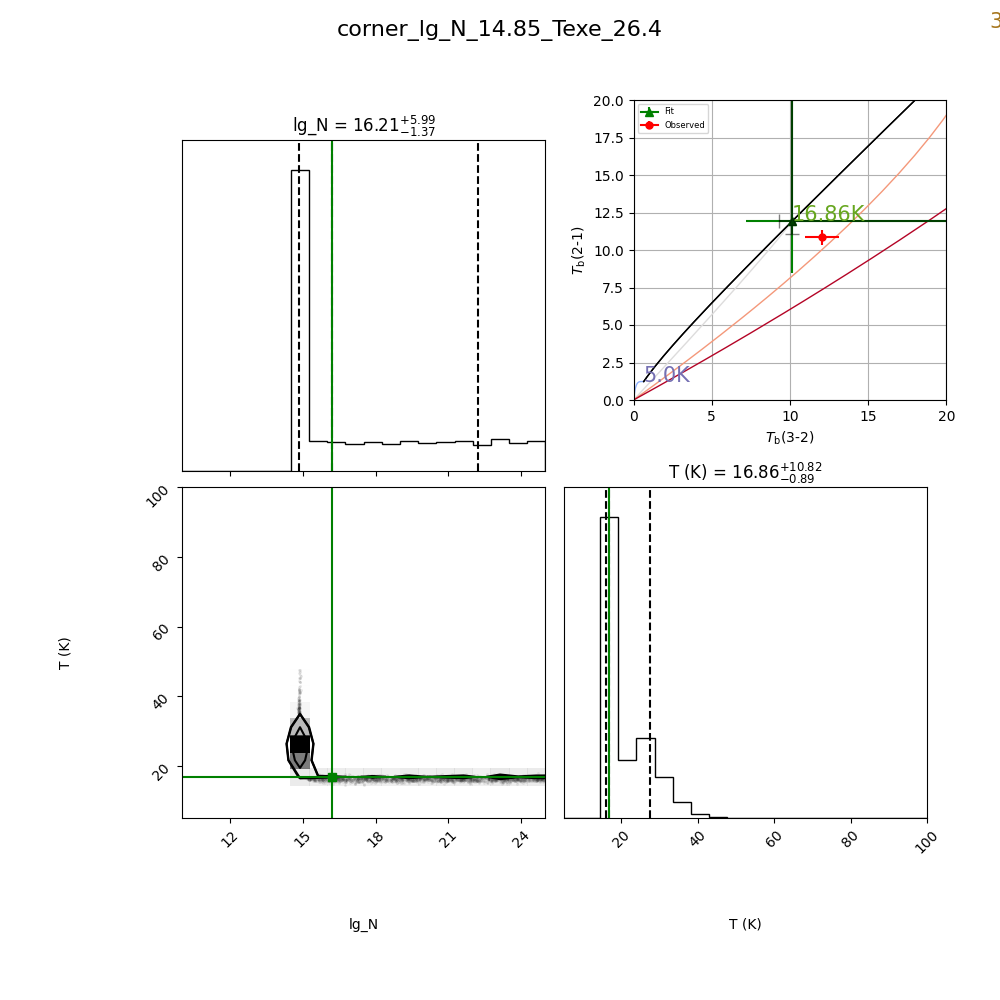

estimating for i = 6 , Tb7 = 10.3, Tb6 = 12.1


100%|██████████| 10000/10000 [00:24<00:00, 403.47it/s]


dtauv_dT =  27.150888990392037
dtauv_dT =  15.198745780788718
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.93, Tb6_dIv_dT = 0.97
Ncols and lgNcols up 1.62e+23, lgNc = 2.32e+01
Ncols and lgNcols med 6.33e+19, lgNc = 1.98e+01
Ncols and lgNcols dwn 2.30e+16, lgNc = 1.64e+01
del T -> + 0.51, - 0.46
del N -> + 1.62e+23, - 6.32e+19
[[0.42973678 0.47328411]]
[[0.44685252 0.49213427]]


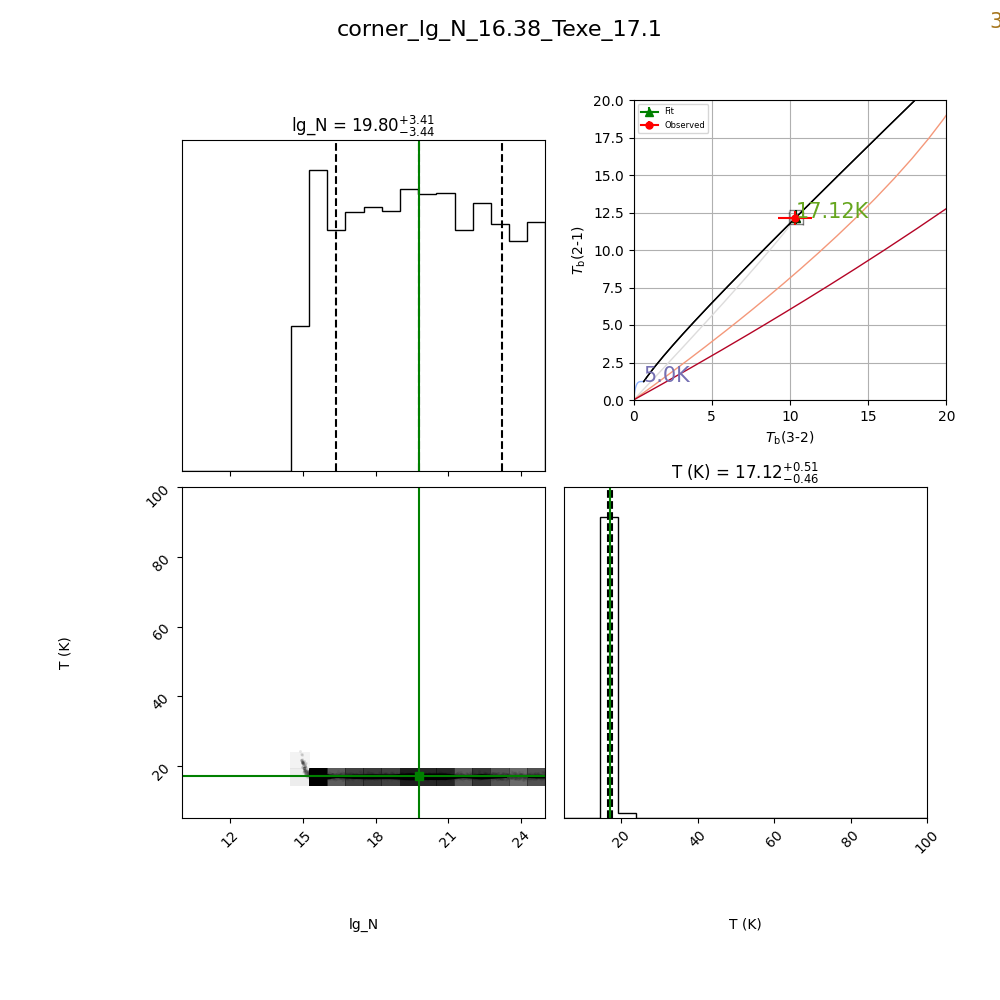

estimating for i = 7 , Tb7 = 11.4, Tb6 = 11.7


100%|██████████| 10000/10000 [00:24<00:00, 402.89it/s]


dtauv_dT =  18.862272529573392
dtauv_dT =  10.645078520883619
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.93, Tb6_dIv_dT = 0.97
Ncols and lgNcols up 1.90e+23, lgNc = 2.33e+01
Ncols and lgNcols med 4.24e+19, lgNc = 1.96e+01
Ncols and lgNcols dwn 5.55e+15, lgNc = 1.57e+01
del T -> + 0.67, - 0.52
del N -> + 1.90e+23, - 4.24e+19
[[0.48113068 0.61966269]]
[[0.50063563 0.6447837 ]]


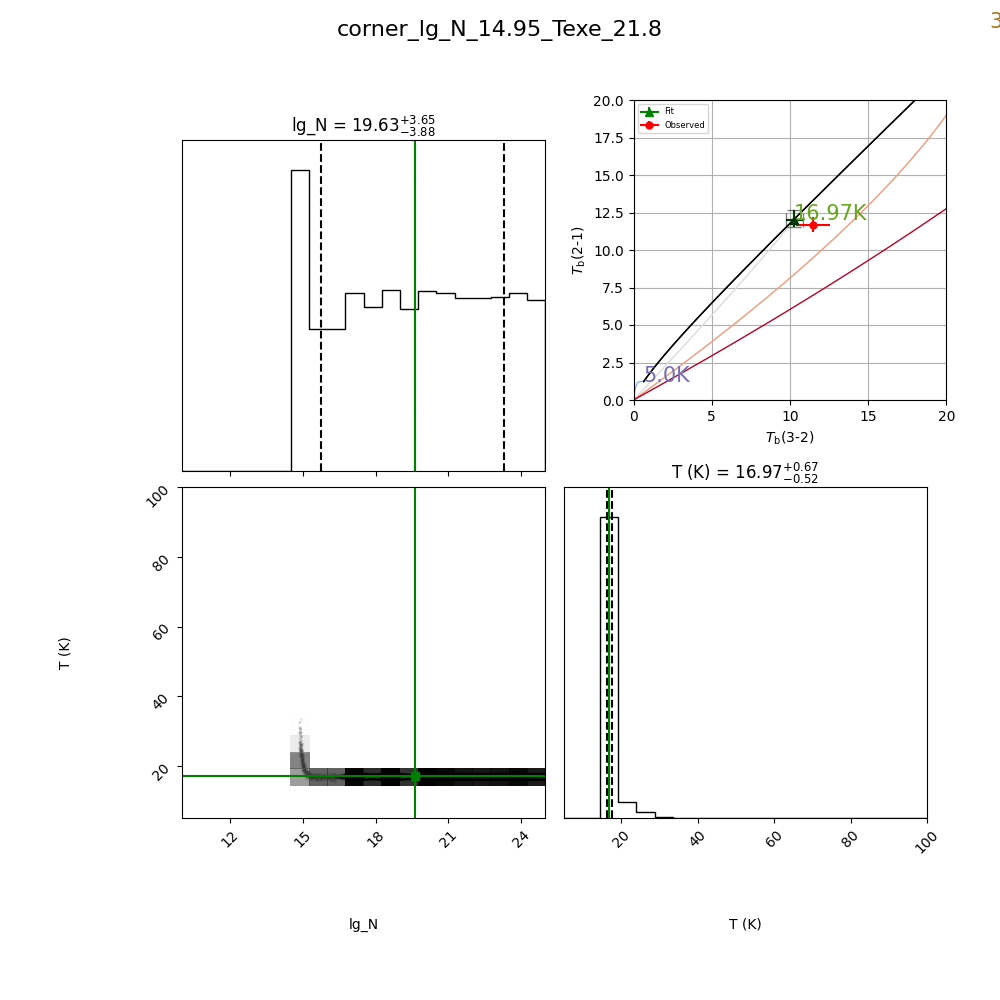

estimating for i = 8 , Tb7 = 5.3, Tb6 = 3.6


100%|██████████| 10000/10000 [00:22<00:00, 444.83it/s]


dtauv_dT =  3.955423996912661e-06
dtauv_dT =  1.358552472758574e-06
Tb7_dIv_dN = 2.04e-14, Tb6_dIv_dN = 1.54e-14
Tb7_dIv_dT = 0.24, Tb6_dIv_dT = 0.16
Ncols and lgNcols up 2.50e+20, lgNc = 2.04e+01
Ncols and lgNcols med 3.01e+14, lgNc = 1.45e+01
Ncols and lgNcols dwn 2.11e+14, lgNc = 1.43e+01
del T -> + 37.60, - 27.95
del N -> + 2.50e+20, - 8.98e+13
[[6.73589082 9.07650852]]
[[4.53944491 6.11933954]]


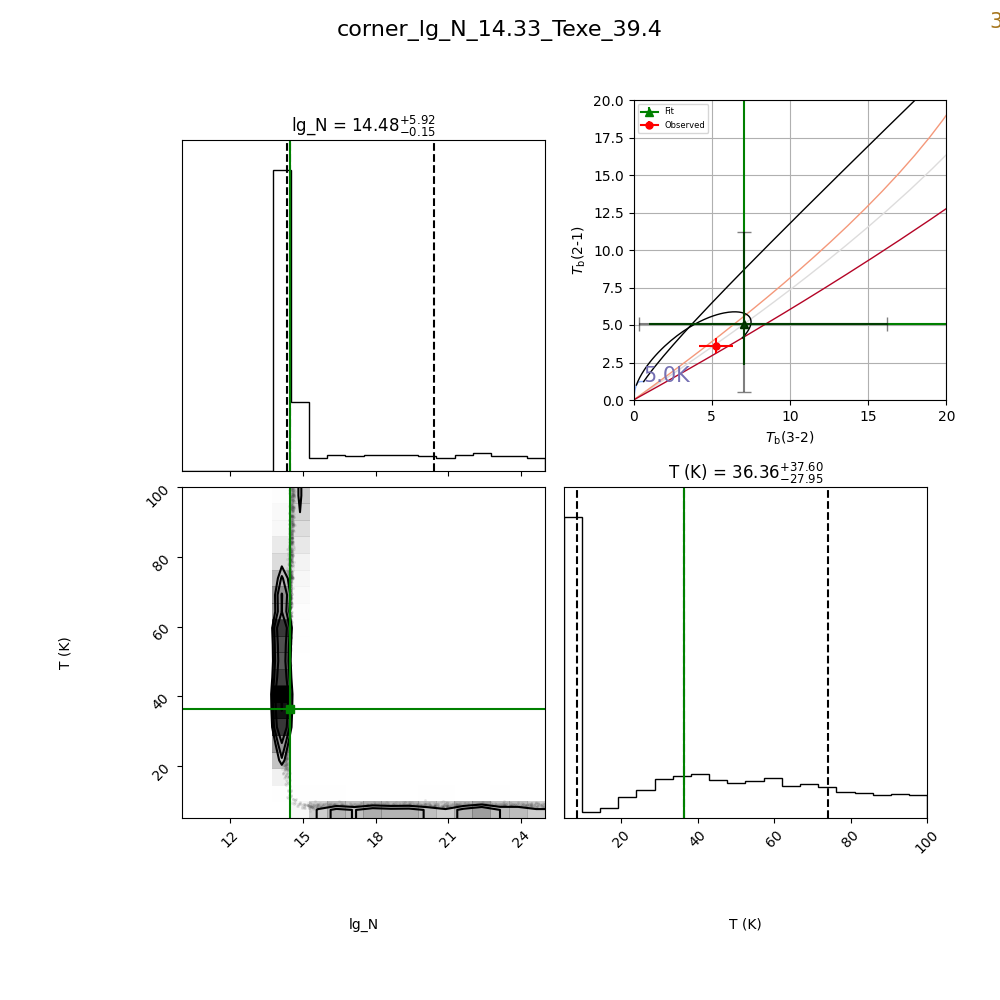

estimating for i = 9 , Tb7 = 5.6, Tb6 = 7.1


100%|██████████| 10000/10000 [00:24<00:00, 406.78it/s]


dtauv_dT =  46.686076675658796
dtauv_dT =  39.35310998372034
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.86, Tb6_dIv_dT = 0.94
Ncols and lgNcols up 1.85e+23, lgNc = 2.33e+01
Ncols and lgNcols med 2.86e+19, lgNc = 1.95e+01
Ncols and lgNcols dwn 8.64e+15, lgNc = 1.59e+01
del T -> + 0.58, - 0.50
del N -> + 1.85e+23, - 2.86e+19
[[0.43065501 0.49936149]]
[[0.46675416 0.54121988]]


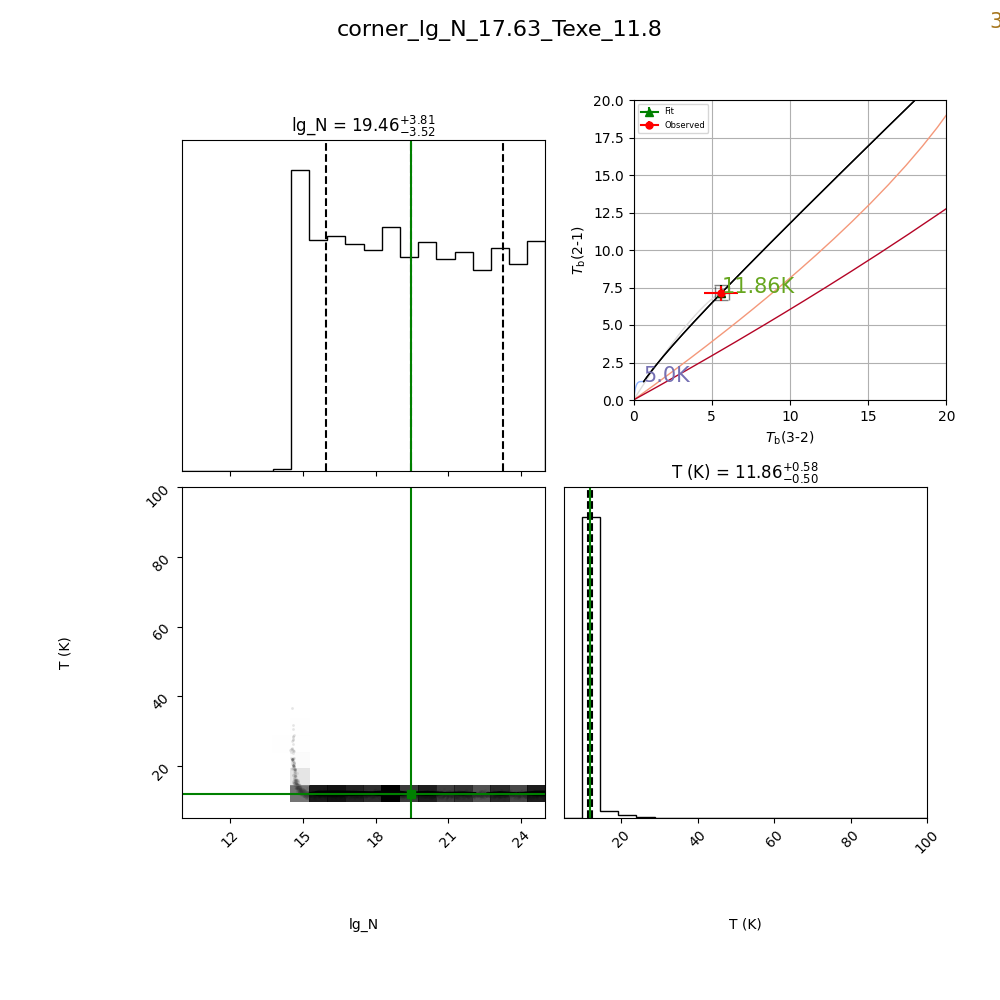

estimating for i = 10 , Tb7 = 6.4, Tb6 = 7.5


100%|██████████| 10000/10000 [00:24<00:00, 405.22it/s]


dtauv_dT =  32.32800817107344
dtauv_dT =  25.847024774669443
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.87, Tb6_dIv_dT = 0.94
Ncols and lgNcols up 1.61e+23, lgNc = 2.32e+01
Ncols and lgNcols med 2.26e+19, lgNc = 1.94e+01
Ncols and lgNcols dwn 5.30e+15, lgNc = 1.57e+01
del T -> + 0.61, - 0.52
del N -> + 1.61e+23, - 2.26e+19
[[0.45289386 0.5330728 ]]
[[0.48785154 0.57421928]]


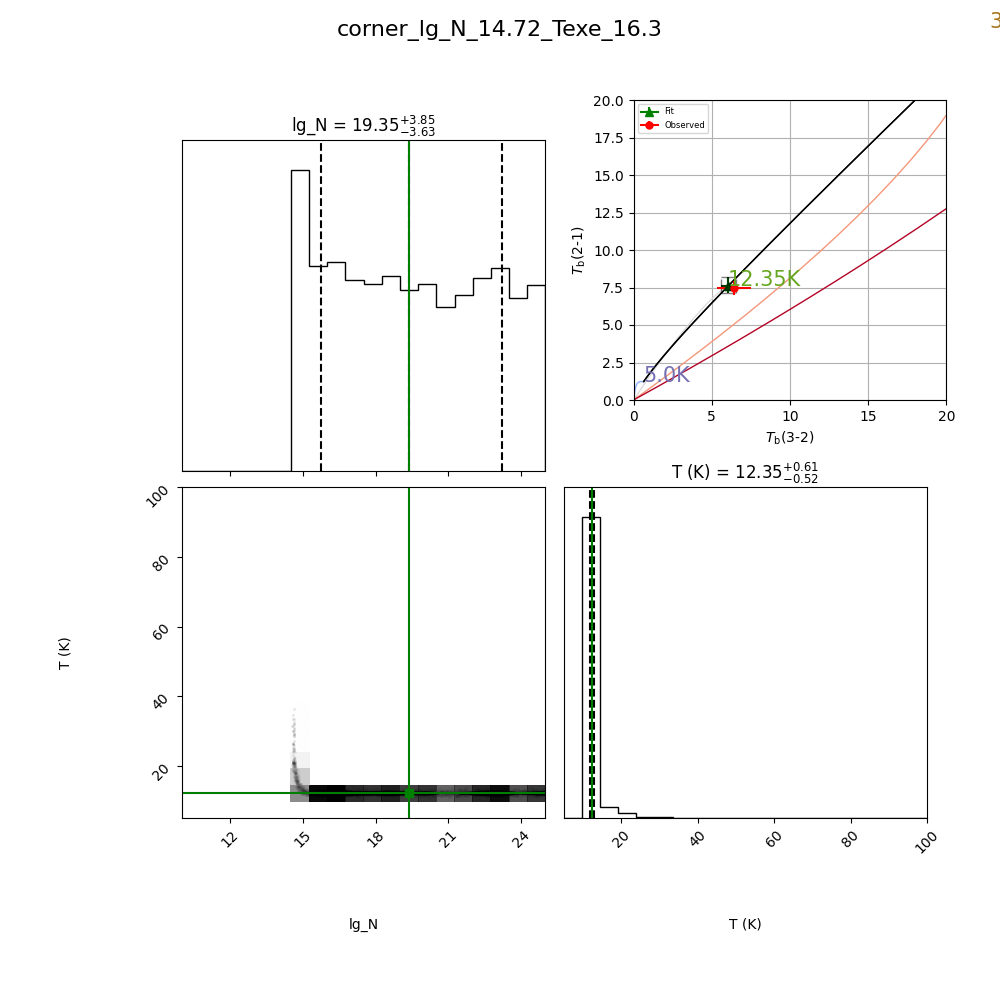

estimating for i = 11 , Tb7 = 11.6, Tb6 = 8.3


100%|██████████| 10000/10000 [00:24<00:00, 406.32it/s]


dtauv_dT =  5.414548023704068e-06
dtauv_dT =  1.807645786151539e-06
Tb7_dIv_dN = 1.63e-14, Tb6_dIv_dN = 1.31e-14
Tb7_dIv_dT = 0.39, Tb6_dIv_dT = 0.26
Ncols and lgNcols up 2.15e+17, lgNc = 1.73e+01
Ncols and lgNcols med 5.82e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 5.18e+14, lgNc = 1.47e+01
del T -> + 16.24, - 24.55
del N -> + 2.15e+17, - 6.39e+13
[[9.4558256  6.25658201]]
[[6.46311964 4.27641539]]


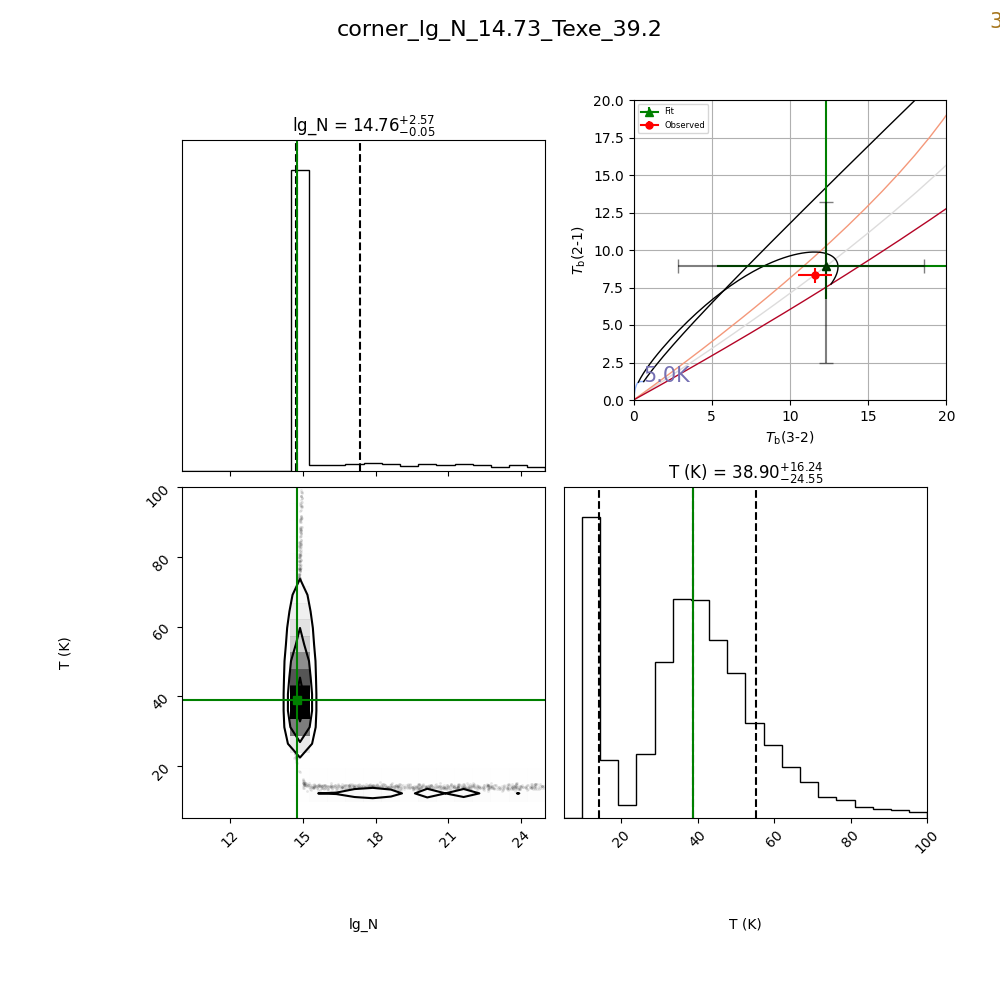

estimating for i = 12 , Tb7 = 2.3, Tb6 = 3.4


100%|██████████| 10000/10000 [00:23<00:00, 425.57it/s]


dtauv_dT =  10.218238187659422
dtauv_dT =  16.446481094256516
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.73, Tb6_dIv_dT = 0.87
Ncols and lgNcols up 8.69e+22, lgNc = 2.29e+01
Ncols and lgNcols med 2.30e+18, lgNc = 1.84e+01
Ncols and lgNcols dwn 2.21e+14, lgNc = 1.43e+01
del T -> + 4.30, - 0.66
del N -> + 8.69e+22, - 2.30e+18
[[0.48187973 3.13631678]]
[[0.57310394 3.73004999]]


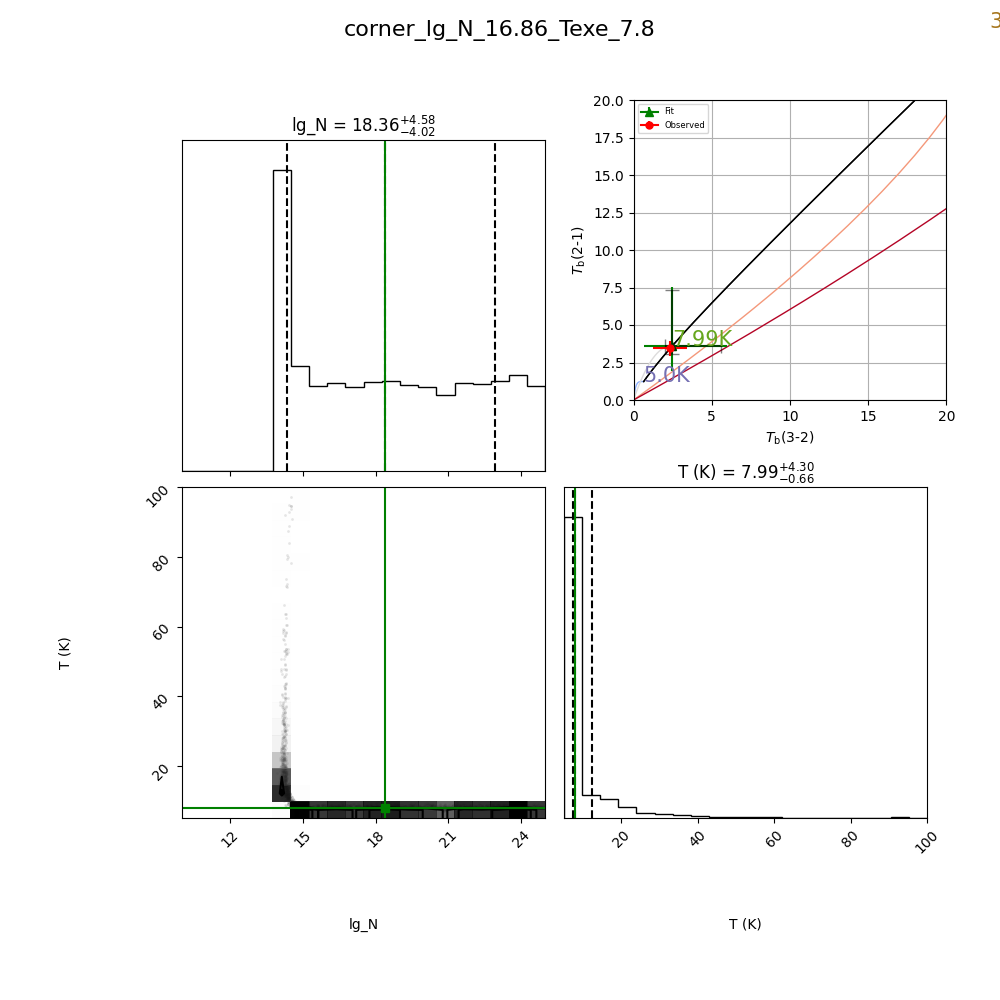

estimating for i = 13 , Tb7 = 4.8, Tb6 = 6.2


100%|██████████| 10000/10000 [00:24<00:00, 406.09it/s]


dtauv_dT =  32.907670398787445
dtauv_dT =  30.864548340303774
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.93
Ncols and lgNcols up 1.61e+23, lgNc = 2.32e+01
Ncols and lgNcols med 1.59e+19, lgNc = 1.92e+01
Ncols and lgNcols dwn 2.74e+15, lgNc = 1.54e+01
del T -> + 0.66, - 0.53
del N -> + 1.61e+23, - 1.59e+19
[[0.45052367 0.55426129]]
[[0.49472584 0.60864145]]


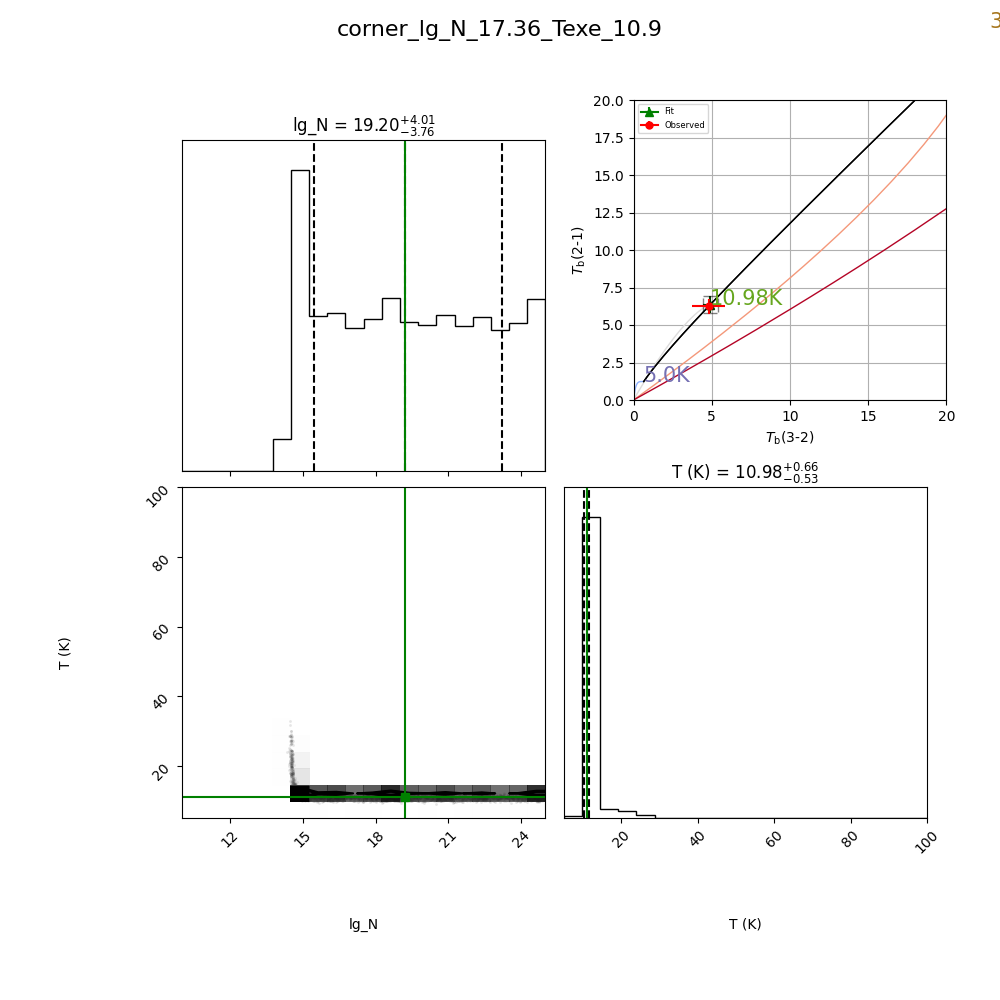

estimating for i = 14 , Tb7 = 13.4, Tb6 = 10.1


100%|██████████| 10000/10000 [00:25<00:00, 389.90it/s]


dtauv_dT =  9.323393553908616e-06
dtauv_dT =  3.209889192831207e-06
Tb7_dIv_dN = 1.41e-14, Tb6_dIv_dN = 1.23e-14
Tb7_dIv_dT = 0.47, Tb6_dIv_dT = 0.34
Ncols and lgNcols up 8.15e+16, lgNc = 1.69e+01
Ncols and lgNcols med 6.90e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 6.40e+14, lgNc = 1.48e+01
del T -> + 9.92, - 19.79
del N -> + 8.08e+16, - 4.95e+13
[[9.29364486 4.65988381]]
[[6.65142969 3.33506283]]


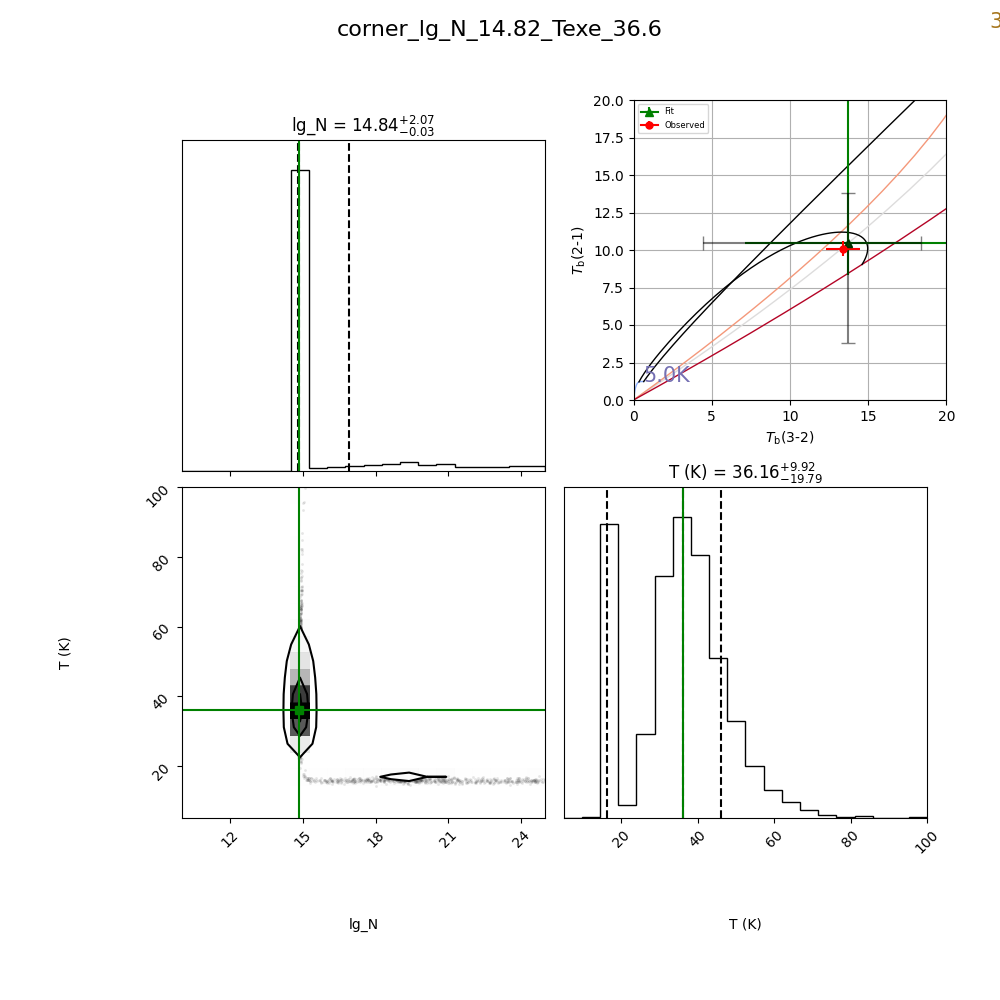

In [18]:
Texe_predicted = []
Texe_upq_predicted = []
Texe_lq_predicted = []

Ncol_predicted = []
Ncol_upq_predicted = []
Ncol_lq_predicted = []

Tb_7_predicts = []
Tb_7_err_predicts = []
Tb_6_predicts = []
Tb_6_err_predicts = []


plot_corner = True

np.random.seed(41)

#N_conv_fraction = 1.e-7
lg_n_bounds = [10.,25.]
T_bounds = [5.,100.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])



ctr = 0

for i, (tb7, tb6) in enumerate(zip(Tb7, Tb6)):

    print(f"estimating for i = {i} , Tb7 = {tb7:.1f}, Tb6 = {tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = tb7, t2=tb6, 
                                                    s1=np.sqrt( 1.08**2),  # (0.1*tb7)**2 + 1.08**2
                                                    s2=np.sqrt( 0.49**2),  # (0.1*tb6)**2 + 0.49**2
                                                estimator='mcmc', like_function = 'chisq', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 10000, burn_in = 1000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(i,3)), str(round(i,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_predicted.append(T_qtls[0])
    Texe_predicted.append(T_qtls[1])
    Texe_upq_predicted.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_predicted.append(Ncol_qtls[0])
    Ncol_predicted.append(Ncol_qtls[1])
    Ncol_upq_predicted.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=tb7, tb6=tb6, figure = fig1,
                                axes = ax)


        Tb_6_predicts.append(Tb_6_prediction[0])
        Tb_6_err_predicts.append(Tb_6_prediction[1])
        
        Tb_7_predicts.append(Tb_7_prediction[0])
        Tb_7_err_predicts.append(Tb_7_prediction[1])


        # fig_lt, ax_lt, Tb_7_predictions, Tb_6_predictions                    
        fig1.suptitle('corner_lg_N_'+str(round(lg_N[i],2))+'_Texe_'+str(round(Texe[i],1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(i,2))+'_v_'+str(round(i,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [19]:
# Calculate errorbars

T_err_predicted = [np.array(Texe_predicted)-np.array(Texe_lq_predicted),np.array(Texe_upq_predicted)-np.array(Texe_predicted)] #[tl,tu] for tl,tu in zip(

N_err_predicted = [np.array(Ncol_predicted)-np.array(Ncol_lq_predicted), np.array(Ncol_upq_predicted)-np.array(Ncol_predicted)]

print(np.shape(T_err_predicted))

(2, 15)


#### Visualize results (Data without noise)

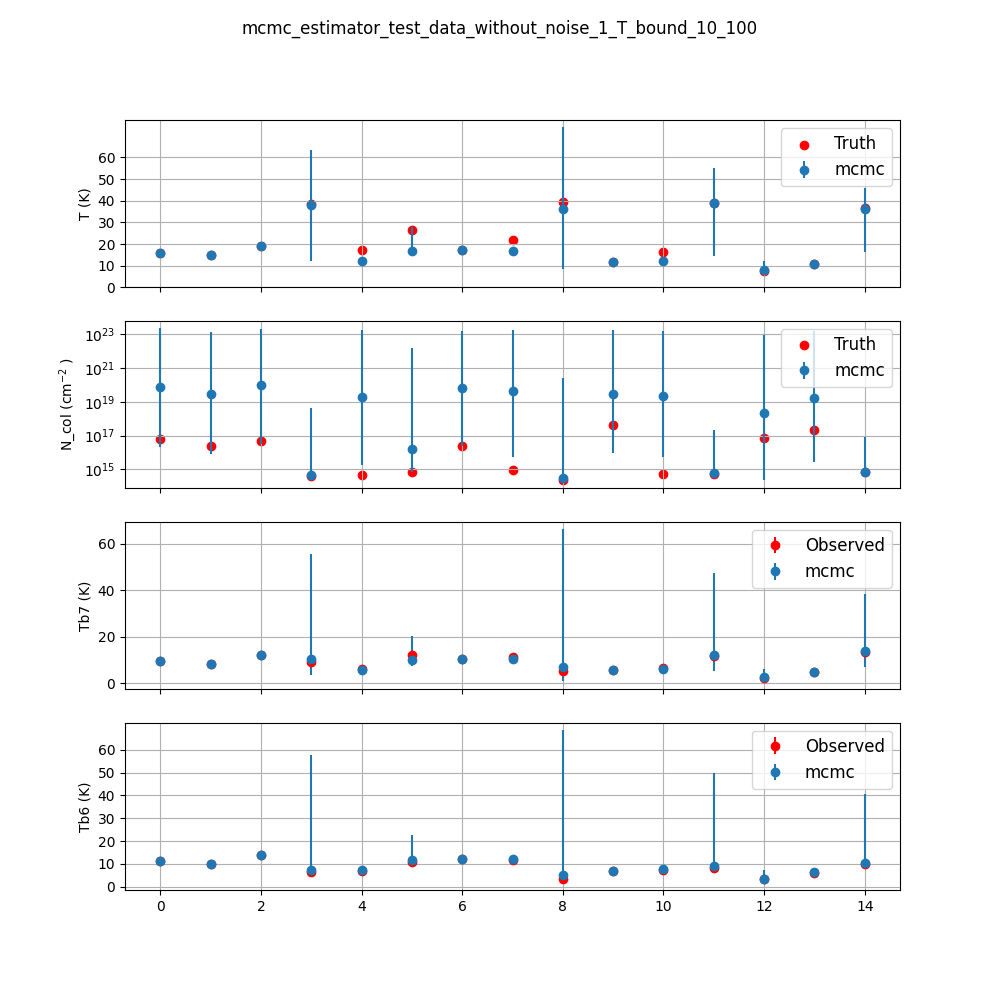

In [20]:
vis_results_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

r = np.arange(len(Texe_predicted))
axes[0].errorbar(r, Texe_predicted, yerr=np.array(T_err_predicted), fmt='o', label = 'mcmc')
axes[0].scatter(r, Texe, marker='o',  color = 'r', label = 'Truth')
axes[0].set_ylabel(r"T (K)")
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].grid(True)
axes[0].legend(prop={'size': 12})

axes[1].errorbar(r, np.array(Ncol_predicted), yerr=np.array(N_err_predicted), fmt='o', label = 'mcmc')
axes[1].scatter(r, 10**np.array(lg_N), marker='o', color = 'r', label = 'Truth')
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 12})


axes[2].errorbar(r, np.array(Tb7), yerr= np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), color = 'r', 
                 label = 'Observed',  fmt='o')
axes[2].errorbar(r, np.array(Tb_7_predicts), yerr=np.array(np.squeeze(Tb_7_err_predicts)).T, fmt='o', label = 'mcmc')
axes[2].set_ylabel(r"Tb7 (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 12})


axes[3].errorbar(r, np.array(Tb6), yerr= np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), color = 'r', label = 'Observed', fmt='o')
axes[3].errorbar(r, np.array(Tb_6_predicts), yerr=np.array(np.squeeze(Tb_6_err_predicts)).T, fmt='o', label = 'mcmc')
axes[3].set_ylabel(r"Tb6 (K)")
axes[3].set_yticks([0,10,20,30,40,50,60])
axes[3].grid(True)
axes[3].legend(prop={'size': 12})

vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  op_dir_label+".jpeg"
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')
plt.show()

#### Data visualization (data within fluxcal+rms noise)

lg_N [16.78, 16.41, 16.68, 14.61, 14.65, 14.85, 16.38, 14.95, 14.33, 17.63, 14.72, 14.73, 16.86, 17.36, 14.82]
lg T [16.02, 14.8, 18.92, 38.37, 17.24, 26.41, 17.09, 21.76, 39.4, 11.82, 16.35, 39.19, 7.79, 10.9, 36.56]


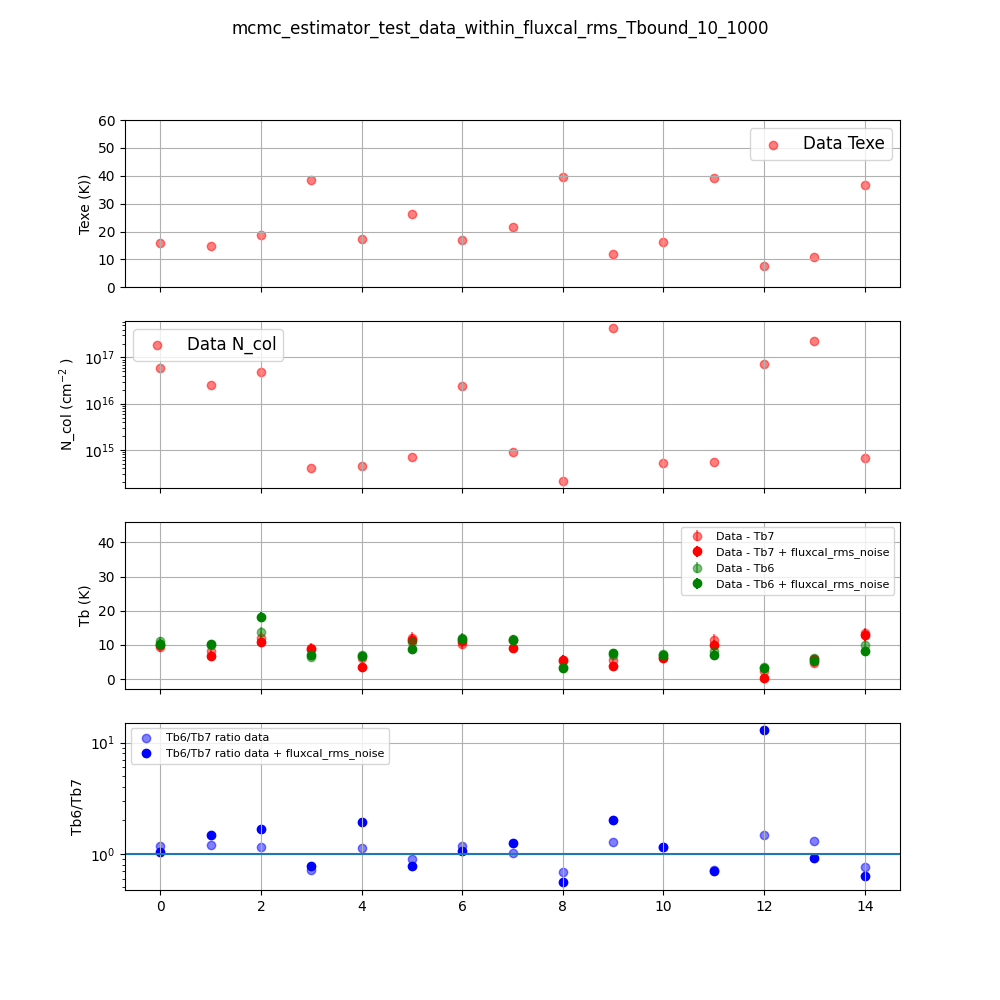

In [21]:
op_dir_label = "mcmc_estimator_test_data_within_fluxcal_rms_Tbound_10_1000"
print("lg_N",[round(n,2) for n in lg_N])
print("lg T",[round(t,2) for t in Texe])


vis_data_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

# N_conv_fraction = 1.e-7
r = np.arange(len(Tb7))


axes[0].scatter(r, Texe, marker='o', color = 'r', label = 'Data Texe',  alpha = 0.5)
axes[0].set_ylabel(r"Texe (K))")
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].grid(True)
axes[0].legend(prop={'size': 12})

axes[1].scatter(r, 10**np.array(lg_N), marker='o', color = 'r', label = 'Data N_col', alpha = 0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yticks([1.e9,1.e10,1.e11,1.e12,1.e13,1.e14,1.e15,1.e16, 1.e17])
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 12})

axes[2].errorbar(r, Tb7, yerr=np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), 
                 label = 'Data - Tb7', fmt='o', color='r', alpha = 0.5)
axes[2].errorbar(r, Tb7_with_rand_error, yerr=np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), 
                 label = 'Data - Tb7 + fluxcal_rms_noise', color='r', fmt='o')
axes[2].errorbar(r, Tb6, yerr=np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), 
                 label = 'Data - Tb6', fmt='o', color='g',alpha = 0.5)
axes[2].errorbar(r, Tb6_with_rand_error, yerr=np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), 
                 label = 'Data - Tb6 + fluxcal_rms_noise', color='g', fmt='o')
axes[2].set_yticks([0,10,20,30,40])
axes[2].set_ylim([-2.9,46])
axes[2].set_ylabel(r"Tb (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 8})

axes[3].scatter(r, np.array(Tb6)/np.array(Tb7), marker='o', label = 'Tb6/Tb7 ratio data', color='blue', alpha = 0.5)
axes[3].scatter(r, np.array(Tb6_with_rand_error)/np.array(Tb7_with_rand_error), marker='o', 
                label = 'Tb6/Tb7 ratio data + fluxcal_rms_noise', color='blue')
axes[3].axhline(y=1)
axes[3].set_ylabel(r"Tb6/Tb7")
axes[3].set_yscale('log')
axes[3].grid(True)
axes[3].legend(prop={'size': 8})


vis_data_fig.suptitle(op_dir_label)

vis_results_figname =  op_dir_label + ".jpeg"
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_data_figpath = os.path.join(dir_path, vis_results_figname)
vis_data_fig.savefig(fname = vis_data_figpath, dpi=300, format='jpeg')



#### T estimation loop (data with noise within fluxcal+rms noise)

In [22]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

In [23]:
Texe_predicted = []
Texe_upq_predicted = []
Texe_lq_predicted = []

Ncol_predicted = []
Ncol_upq_predicted = []
Ncol_lq_predicted = []

Tb_7_predicts = []
Tb_7_err_predicts = []
Tb_6_predicts = []
Tb_6_err_predicts = []


plot_corner = True

np.random.seed(41)

#N_conv_fraction = 1.e-7
lg_n_bounds = [10.,25.]
T_bounds = [5.,100.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])



ctr = 0

for i, (tb7, tb6) in enumerate(zip(Tb7_with_rand_error, Tb6_with_rand_error)):

    print(f"estimating for i = {i} , Tb7 = {tb7:.1f}, Tb6 = {tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = tb7, t2=tb6, 
                                                    s1=np.sqrt((0.1*tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*tb6)**2 + 0.49**2), 
                                                estimator='mcmc', like_function = 'chisq', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 5000, burn_in = 1000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(i,3)), str(round(i,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_predicted.append(T_qtls[0])
    Texe_predicted.append(T_qtls[1])
    Texe_upq_predicted.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_predicted.append(Ncol_qtls[0])
    Ncol_predicted.append(Ncol_qtls[1])
    Ncol_upq_predicted.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=tb7, tb6=tb6, figure = fig1,
                                axes = ax)


        Tb_6_predicts.append(Tb_6_prediction[0])
        Tb_6_err_predicts.append(Tb_6_prediction[1])
        
        Tb_7_predicts.append(Tb_7_prediction[0])
        Tb_7_err_predicts.append(Tb_7_prediction[1])


        # fig_lt, ax_lt, Tb_7_predictions, Tb_6_predictions                    
        fig1.suptitle('corner_lg_N_'+str(round(lg_N[i],2))+'_Texe_'+str(round(Texe[i],1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(i,2))+'_v_'+str(round(i,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        plt.close()

    ctr = ctr+1


estimating for i = 0 , Tb7 = 10.0, Tb6 = 10.4


100%|██████████| 5000/5000 [00:25<00:00, 198.76it/s]


dtauv_dT =  14.735623264796914
dtauv_dT =  8.790516328454123
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.92, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 1.70e+23, lgNc = 2.32e+01
Ncols and lgNcols med 2.63e+19, lgNc = 1.94e+01
Ncols and lgNcols dwn 4.11e+15, lgNc = 1.56e+01
del T -> + 1.29, - 1.03
del N -> + 1.70e+23, - 2.63e+19
[[0.94852894 1.187663  ]]
[[0.99175001 1.24178056]]
estimating for i = 1 , Tb7 = 6.9, Tb6 = 10.2


100%|██████████| 5000/5000 [00:12<00:00, 399.81it/s]


dtauv_dT =  50.75390237924078
dtauv_dT =  33.78330644060659
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.91, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 1.57e+23, lgNc = 2.32e+01
Ncols and lgNcols med 6.08e+19, lgNc = 1.98e+01
Ncols and lgNcols dwn 1.13e+16, lgNc = 1.61e+01
del T -> + 0.98, - 0.92
del N -> + 1.57e+23, - 6.08e+19
[[0.83128231 0.88900279]]
[[0.87815771 0.939133  ]]
estimating for i = 2 , Tb7 = 10.9, Tb6 = 18.3


100%|██████████| 5000/5000 [00:12<00:00, 398.83it/s]


dtauv_dT =  17.829545005397037
dtauv_dT =  8.702417109563108
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.95, Tb6_dIv_dT = 0.98
Ncols and lgNcols up 2.98e+23, lgNc = 2.35e+01
Ncols and lgNcols med 8.15e+19, lgNc = 1.99e+01
Ncols and lgNcols dwn 5.03e+16, lgNc = 1.67e+01
del T -> + 1.13, - 1.28
del N -> + 2.98e+23, - 8.15e+19
[[1.21344261 1.07803923]]
[[1.24839642 1.10909268]]
estimating for i = 3 , Tb7 = 9.0, Tb6 = 7.0


100%|██████████| 5000/5000 [00:11<00:00, 433.54it/s]


dtauv_dT =  2.969562859142937e-05
dtauv_dT =  1.1831953367718655e-05
Tb7_dIv_dN = 1.31e-14, Tb6_dIv_dN = 1.27e-14
Tb7_dIv_dT = 0.50, Tb6_dIv_dT = 0.39
Ncols and lgNcols up 1.76e+20, lgNc = 2.02e+01
Ncols and lgNcols med 5.30e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 4.09e+14, lgNc = 1.46e+01
del T -> + 29.92, - 14.61
del N -> + 1.76e+20, - 1.22e+14
[[ 7.23183476 14.81499759]]
[[ 5.76735051 11.81555857]]
estimating for i = 4 , Tb7 = 3.4, Tb6 = 6.6


100%|██████████| 5000/5000 [00:12<00:00, 405.88it/s]


dtauv_dT =  23.763872831866156
dtauv_dT =  22.803648521621934
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 9.41e+22, lgNc = 2.30e+01
Ncols and lgNcols med 1.10e+19, lgNc = 1.90e+01
Ncols and lgNcols dwn 3.09e+15, lgNc = 1.55e+01
del T -> + 0.87, - 0.80
del N -> + 9.41e+22, - 1.10e+19
[[0.67170215 0.73379141]]
[[0.73976337 0.80814392]]
estimating for i = 5 , Tb7 = 11.5, Tb6 = 8.9


100%|██████████| 5000/5000 [00:11<00:00, 421.36it/s]


dtauv_dT =  1.3150415978293616e-05
dtauv_dT =  4.691745332201791e-06
Tb7_dIv_dN = 1.37e-14, Tb6_dIv_dN = 1.23e-14
Tb7_dIv_dT = 0.49, Tb6_dIv_dT = 0.36
Ncols and lgNcols up 3.24e+18, lgNc = 1.85e+01
Ncols and lgNcols med 6.56e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 5.38e+14, lgNc = 1.47e+01
del T -> + 27.37, - 18.16
del N -> + 3.24e+18, - 1.17e+14
[[ 8.82139538 13.2972465 ]]
[[6.50320902 9.80284548]]
estimating for i = 6 , Tb7 = 11.0, Tb6 = 11.8


100%|██████████| 5000/5000 [00:12<00:00, 405.06it/s]


dtauv_dT =  8.474149090691224
dtauv_dT =  4.6966186813290545
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.93, Tb6_dIv_dT = 0.97
Ncols and lgNcols up 1.82e+23, lgNc = 2.33e+01
Ncols and lgNcols med 2.06e+19, lgNc = 1.93e+01
Ncols and lgNcols dwn 4.53e+15, lgNc = 1.57e+01
del T -> + 1.41, - 1.05
del N -> + 1.82e+23, - 2.06e+19
[[0.97545493 1.31393016]]
[[1.01346258 1.36512616]]
estimating for i = 7 , Tb7 = 9.1, Tb6 = 11.4


100%|██████████| 5000/5000 [00:12<00:00, 400.06it/s]


dtauv_dT =  23.226372591459782
dtauv_dT =  13.71404468267322
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.92, Tb6_dIv_dT = 0.97
Ncols and lgNcols up 2.14e+23, lgNc = 2.33e+01
Ncols and lgNcols med 4.32e+19, lgNc = 1.96e+01
Ncols and lgNcols dwn 9.75e+15, lgNc = 1.60e+01
del T -> + 1.17, - 0.96
del N -> + 2.14e+23, - 4.32e+19
[[0.88628353 1.08459484]]
[[0.92582298 1.13298149]]
estimating for i = 8 , Tb7 = 5.7, Tb6 = 3.2


100%|██████████| 5000/5000 [00:10<00:00, 455.93it/s]


dtauv_dT =  0.012595633793240508
dtauv_dT =  0.015606040076908113
Tb7_dIv_dN = 1.66e-18, Tb6_dIv_dN = 7.65e-21
Tb7_dIv_dT = 0.79, Tb6_dIv_dT = 0.90
Ncols and lgNcols up 1.70e+22, lgNc = 2.22e+01
Ncols and lgNcols med 3.81e+15, lgNc = 1.56e+01
Ncols and lgNcols dwn 2.23e+14, lgNc = 1.43e+01
del T -> + 66.54, - 1.35
del N -> + 1.70e+22, - 3.58e+15
[[ 1.06500454 52.32366282]]
[[ 1.21551306 59.71814493]]
estimating for i = 9 , Tb7 = 3.9, Tb6 = 7.7


100%|██████████| 5000/5000 [00:12<00:00, 403.38it/s]


dtauv_dT =  69.48573235529953
dtauv_dT =  59.948167529150645
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.86, Tb6_dIv_dT = 0.93
Ncols and lgNcols up 1.40e+23, lgNc = 2.31e+01
Ncols and lgNcols med 4.03e+19, lgNc = 1.96e+01
Ncols and lgNcols dwn 1.05e+16, lgNc = 1.60e+01
del T -> + 0.83, - 0.89
del N -> + 1.40e+23, - 4.03e+19
[[0.76901876 0.71056338]]
[[0.83579366 0.77226252]]
estimating for i = 10 , Tb7 = 6.1, Tb6 = 7.1


100%|██████████| 5000/5000 [00:12<00:00, 410.45it/s]


dtauv_dT =  64.98951260383527
dtauv_dT =  53.28173066996901
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.87, Tb6_dIv_dT = 0.94
Ncols and lgNcols up 1.88e+23, lgNc = 2.33e+01
Ncols and lgNcols med 4.26e+19, lgNc = 1.96e+01
Ncols and lgNcols dwn 3.43e+15, lgNc = 1.55e+01
del T -> + 1.04, - 0.82
del N -> + 1.88e+23, - 4.26e+19
[[0.71351339 0.90853891]]
[[0.77081063 0.98149727]]
estimating for i = 11 , Tb7 = 10.0, Tb6 = 7.0


100%|██████████| 5000/5000 [00:11<00:00, 432.98it/s]


dtauv_dT =  2.302247035341794e-06
dtauv_dT =  7.28004816729563e-07
Tb7_dIv_dN = 1.81e-14, Tb6_dIv_dN = 1.32e-14
Tb7_dIv_dT = 0.30, Tb6_dIv_dT = 0.19
Ncols and lgNcols up 2.59e+16, lgNc = 1.64e+01
Ncols and lgNcols med 5.21e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 4.21e+14, lgNc = 1.46e+01
del T -> + 30.34, - 31.06
del N -> + 2.54e+16, - 1.01e+14
[[9.33438574 9.11551234]]
[[5.98593059 5.84557202]]
estimating for i = 12 , Tb7 = 0.3, Tb6 = 3.3


100%|██████████| 5000/5000 [00:11<00:00, 421.45it/s]


dtauv_dT =  9.640290754226971
dtauv_dT =  18.675829160694303
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.69, Tb6_dIv_dT = 0.84
Ncols and lgNcols up 7.99e+22, lgNc = 2.29e+01
Ncols and lgNcols med 1.88e+18, lgNc = 1.83e+01
Ncols and lgNcols dwn 3.60e+14, lgNc = 1.46e+01
del T -> + 1.16, - 0.71
del N -> + 7.99e+22, - 1.88e+18
[[0.48539329 0.79454208]]
[[0.5962091  0.97593689]]
estimating for i = 13 , Tb7 = 5.9, Tb6 = 5.4


100%|██████████| 5000/5000 [00:11<00:00, 423.77it/s]


dtauv_dT =  4.568473478316298
dtauv_dT =  4.36927874229892
Tb7_dIv_dN = 0.00e+00, Tb6_dIv_dN = 0.00e+00
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 5.49e+22, lgNc = 2.27e+01
Ncols and lgNcols med 2.13e+18, lgNc = 1.83e+01
Ncols and lgNcols dwn 3.44e+14, lgNc = 1.45e+01
del T -> + 10.51, - 0.91
del N -> + 5.49e+22, - 2.13e+18
[[0.76176249 8.83106829]]
[[0.8385893  9.72171702]]
estimating for i = 14 , Tb7 = 12.9, Tb6 = 8.2


100%|██████████| 5000/5000 [00:11<00:00, 432.30it/s]


dtauv_dT =  8.383117995717108e-07
dtauv_dT =  2.457477363639581e-07
Tb7_dIv_dN = 1.71e-14, Tb6_dIv_dN = 1.16e-14
Tb7_dIv_dT = 0.28, Tb6_dIv_dT = 0.17
Ncols and lgNcols up 1.35e+15, lgNc = 1.51e+01
Ncols and lgNcols med 6.92e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 5.71e+14, lgNc = 1.48e+01
del T -> + 25.22, - 40.86
del N -> + 6.60e+14, - 1.22e+14
[[11.47723757  7.08339479]]
[[6.90462534 4.26132045]]


In [24]:
# Calculate errorbars

T_err_predicted = [np.array(Texe_predicted)-np.array(Texe_lq_predicted),np.array(Texe_upq_predicted)-np.array(Texe_predicted)] #[tl,tu] for tl,tu in zip(

N_err_predicted = [np.array(Ncol_predicted)-np.array(Ncol_lq_predicted), np.array(Ncol_upq_predicted)-np.array(Ncol_predicted)]

print(np.shape(T_err_predicted))

(2, 15)


#### Visualize results (Data with noise)

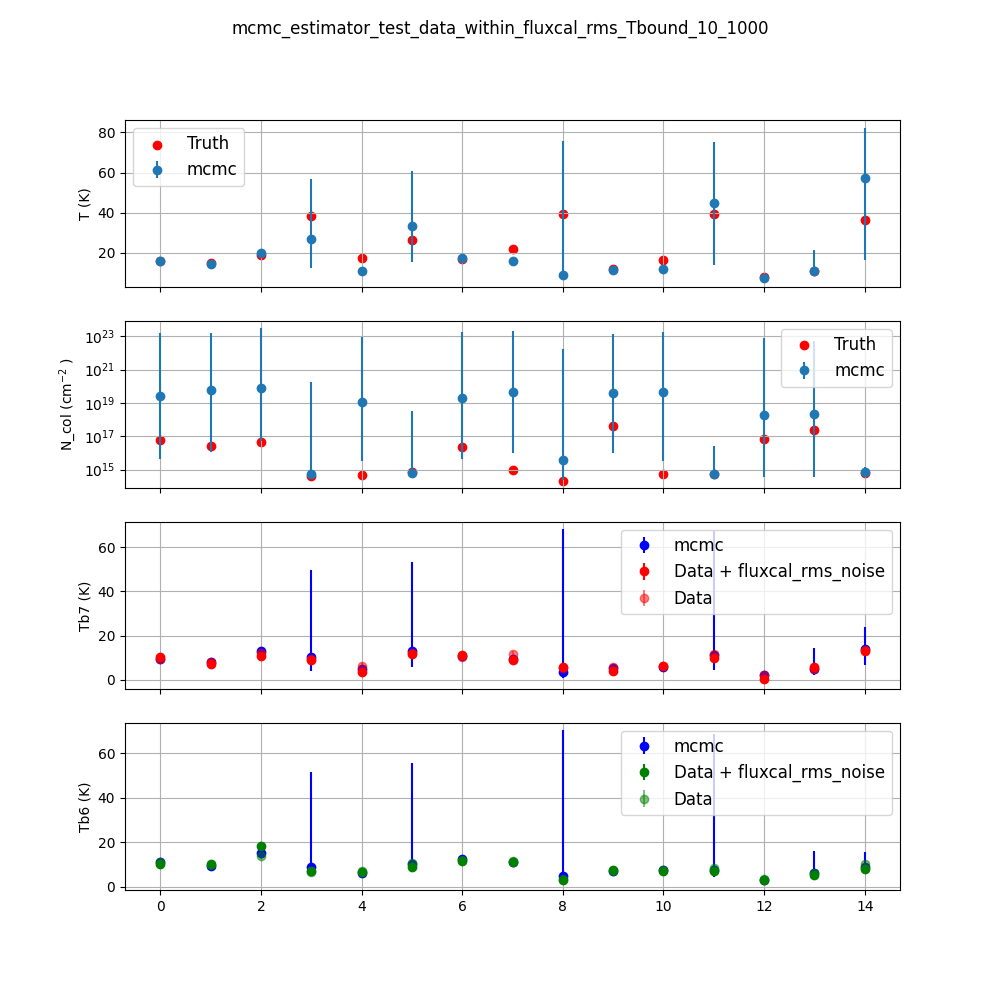

In [27]:
vis_results_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

r = np.arange(len(Texe_predicted))
axes[0].errorbar(r, Texe_predicted, yerr=np.array(T_err_predicted), fmt='o', label = 'mcmc')
axes[0].scatter(r, Texe, marker='o',  color = 'r', label = 'Truth')
axes[0].set_ylabel(r"T (K)")
#axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].grid(True)
axes[0].legend(prop={'size': 12})

axes[1].errorbar(r, np.array(Ncol_predicted), yerr=np.array(N_err_predicted), fmt='o', label = 'mcmc')
axes[1].scatter(r, 10**np.array(lg_N), marker='o', color = 'r', label = 'Truth')
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yscale('log')
#axes[1].set_yticks([1.e9,1.e10,1.e11,1.e12,1.e13,1.e14,1.e15,1.e16, 1.e17])
axes[1].grid(True)
axes[1].legend(prop={'size': 12})

axes[2].errorbar(r, np.array(Tb_7_predicts), yerr=np.array(np.squeeze(Tb_7_err_predicts)).T, fmt='o', label = 'mcmc',
                  color = 'blue')
axes[2].errorbar(r, np.array(Tb7_with_rand_error), yerr= np.sqrt((0.1*np.array(Tb7_with_rand_error))**2 + 1.08**2), color = 'r', 
                 label = 'Data + fluxcal_rms_noise',  fmt='o')
axes[2].errorbar(r, np.array(Tb7), yerr= np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), color = 'r', 
                 label = 'Data',  fmt='o', alpha = 0.5)
axes[2].set_ylabel(r"Tb7 (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 12})

axes[3].errorbar(r, np.array(Tb_6_predicts), yerr=np.array(np.squeeze(Tb_6_err_predicts)).T, fmt='o', label = 'mcmc', color = 'b')
axes[3].errorbar(r, np.array(Tb6_with_rand_error), yerr= np.sqrt((0.1*np.array(Tb6_with_rand_error))**2 + 0.49**2), color = 'g', 
                 label = 'Data + fluxcal_rms_noise',  fmt='o')
axes[3].errorbar(r, np.array(Tb6), yerr= np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), color = 'g', label = 'Data', 
                 fmt='o', alpha = 0.5)
axes[3].set_ylabel(r"Tb6 (K)")
axes[3].grid(True)
axes[3].legend(prop={'size': 12})

vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  op_dir_label + '.jpeg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')
plt.show()